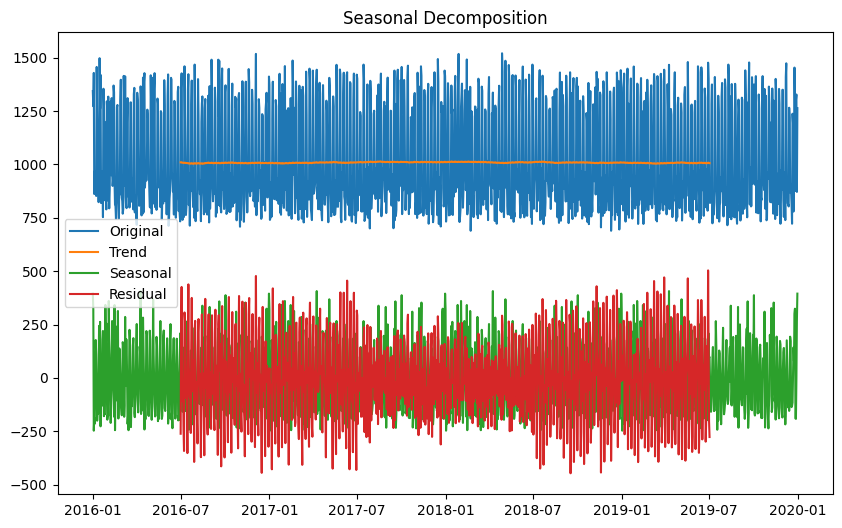

ADF Statistic: -8.444482949261326
p-value: 1.7275721101200837e-13
Stationary


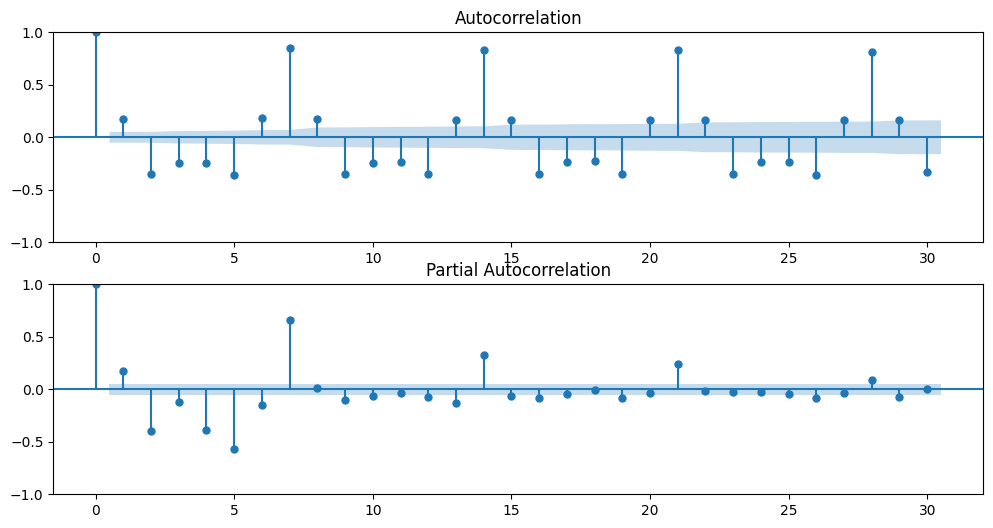

Fitting ARIMA(7,1,7) model


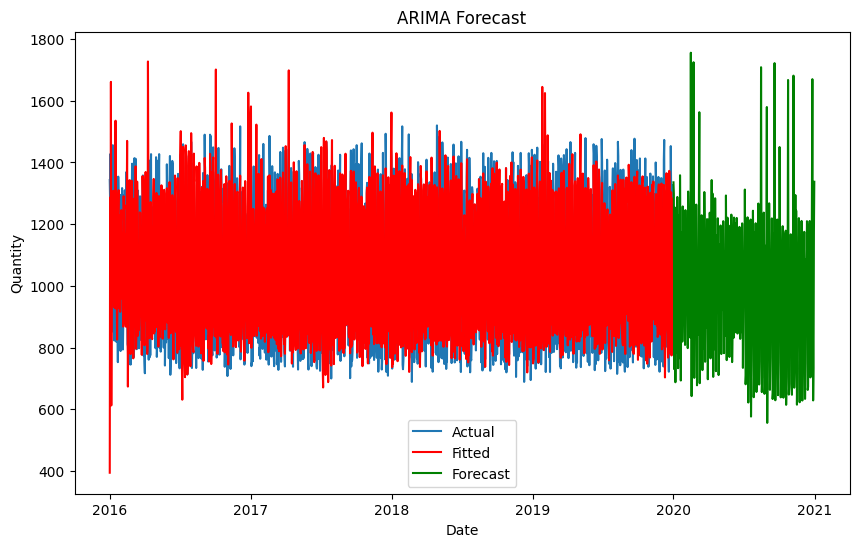

RMSE for 2020: 203.61767989432917
MAE for 2020: 173.72107981168654
MAPE for 2020: 17.840174135271507
Accuracy: 82.15982586472849
Actual Quantity for 2020:
order_date
2020-01-01    1247
2020-01-02     874
2020-01-03     802
2020-01-04    1370
2020-01-05    1262
              ... 
2020-12-27    1404
2020-12-28     790
2020-12-29     804
2020-12-30     934
2020-12-31    1407
Name: quantity, Length: 366, dtype: int64

Predicted Quantity for 2020:
2020-01-01    1335.698813
2020-01-02    1299.476399
2020-01-03     730.306829
2020-01-04    1254.581667
2020-01-05    1072.124568
                 ...     
2020-12-27    1045.264846
2020-12-28     628.939222
2020-12-29     734.370903
2020-12-30    1174.159418
2020-12-31    1337.498695
Freq: D, Name: predicted_mean, Length: 366, dtype: float64


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

# Load the dataset from both sheets
data_dict = pd.read_excel('C:/Users/Abhishek Bhat/sam9.xlsx', sheet_name=None)

# Concatenate DataFrames from all sheets into a single DataFrame
data = pd.concat(data_dict.values(), ignore_index=True)
# Convert 'order_date' column to datetime
data['order_date'] = pd.to_datetime(data['order_date'])

# Filter data for training (2016-01-01 to 2019-12-31)
train_data = data[(data['order_date'] >= '2016-01-01') & (data['order_date'] <= '2019-12-31')]

# Aggregating sales data on a daily basis
daily_sales = train_data.groupby('order_date')['quantity'].sum().reset_index()

# Set 'order_date' as index
daily_sales.set_index('order_date', inplace=True)

# Handle missing values
daily_sales = daily_sales.asfreq('D').fillna(0)

# Seasonal decomposition
decomposition = seasonal_decompose(daily_sales['quantity'], model='additive', period=365)
seasonal = decomposition.seasonal

# Visualize the Data
plt.figure(figsize=(10,6))
plt.plot(daily_sales.index, daily_sales['quantity'], label='Original')
plt.plot(daily_sales.index, decomposition.trend, label='Trend')
plt.plot(daily_sales.index, seasonal, label='Seasonal')
plt.plot(daily_sales.index, decomposition.resid, label='Residual')
plt.legend()
plt.title('Seasonal Decomposition')
plt.show()

# Remove seasonality
daily_sales['deseasonalized'] = daily_sales['quantity'] - seasonal

# Check Stationarity
result = adfuller(daily_sales['deseasonalized'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if(result[1]>0.05):
    print("Non stationary")
else:
    print("Stationary")

# Apply differencing if necessary
if result[1] > 0.05:
    daily_sales['deseasonalized'] = daily_sales['deseasonalized'].diff().dropna()

# Plot ACF and PACF
plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(daily_sales['deseasonalized'].dropna(), ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(daily_sales['deseasonalized'].dropna(), ax=plt.gca(), lags=30)
plt.show()

# Set ARIMA parameters
p, d, q = 7, 1, 7

# Fit ARIMA model with specified parameters
print(f'Fitting ARIMA({p},{d},{q}) model')
model = ARIMA(daily_sales['deseasonalized'].dropna(), order=(p, d, q))
model_fit = model.fit()

# Restore seasonality and forecast for 2020
forecast_deseasonalized = model_fit.forecast(steps=366)
forecast_2020 = forecast_deseasonalized + seasonal[-366:].values

# Plotting the training data and forecast
plt.figure(figsize=(10,6))
plt.plot(daily_sales.index, daily_sales['quantity'], label='Actual')
plt.plot(daily_sales.index, model_fit.fittedvalues + seasonal[-len(model_fit.fittedvalues):].values, color='red', label='Fitted')
plt.plot(pd.date_range(start='2020-01-01', end='2020-12-31'), forecast_2020, color='green', label='Forecast')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

# Prepare actual sales data for 2020
actual_data_2020 = data[(data['order_date'] >= '2020-01-01') & (data['order_date'] <= '2020-12-31')]
actual_daily_sales_2020 = actual_data_2020.groupby('order_date')['quantity'].sum().reset_index()
actual_daily_sales_2020.set_index('order_date', inplace=True)

# Calculate RMSE for 2020
rmse_2020 = np.sqrt(mean_squared_error(actual_daily_sales_2020['quantity'], forecast_2020))
# Calculate MAE for 2020
mae_2020 = mean_absolute_error(actual_daily_sales_2020['quantity'], forecast_2020)
# Calculate MAPE for 2020
mape_2020 = np.mean(np.abs((actual_daily_sales_2020['quantity'] - forecast_2020) / actual_daily_sales_2020['quantity'])) * 100
# Calculate Accuracy for 2020
accuracy = 100 - mape_2020

print('RMSE for 2020:', rmse_2020)
print('MAE for 2020:', mae_2020)
print('MAPE for 2020:', mape_2020)
print('Accuracy:', accuracy)

print("Actual Quantity for 2020:")
print(actual_daily_sales_2020['quantity'])

print("\nPredicted Quantity for 2020:")
print(forecast_2020)



Fitting ARIMA(7,1,7) model for The Barbecue Chicken Pizza with period 7
Fitting ARIMA(7,1,7) model for The Barbecue Chicken Pizza with period 30
Fitting ARIMA(7,1,7) model for The Barbecue Chicken Pizza with period 90
Fitting ARIMA(7,1,7) model for The Barbecue Chicken Pizza with period 365
Best period for The Barbecue Chicken Pizza: 90
Fitting ARIMA(7,1,7) model for The Big Meat Pizza with period 7
Fitting ARIMA(7,1,7) model for The Big Meat Pizza with period 30
Fitting ARIMA(7,1,7) model for The Big Meat Pizza with period 90
Fitting ARIMA(7,1,7) model for The Big Meat Pizza with period 365
Best period for The Big Meat Pizza: 30
Fitting ARIMA(7,1,7) model for The Brie Carre Pizza with period 7
Fitting ARIMA(7,1,7) model for The Brie Carre Pizza with period 30
Fitting ARIMA(7,1,7) model for The Brie Carre Pizza with period 90
Fitting ARIMA(7,1,7) model for The Brie Carre Pizza with period 365
Best period for The Brie Carre Pizza: 90
Fitting ARIMA(7,1,7) model for The Calabrese Pizza wi

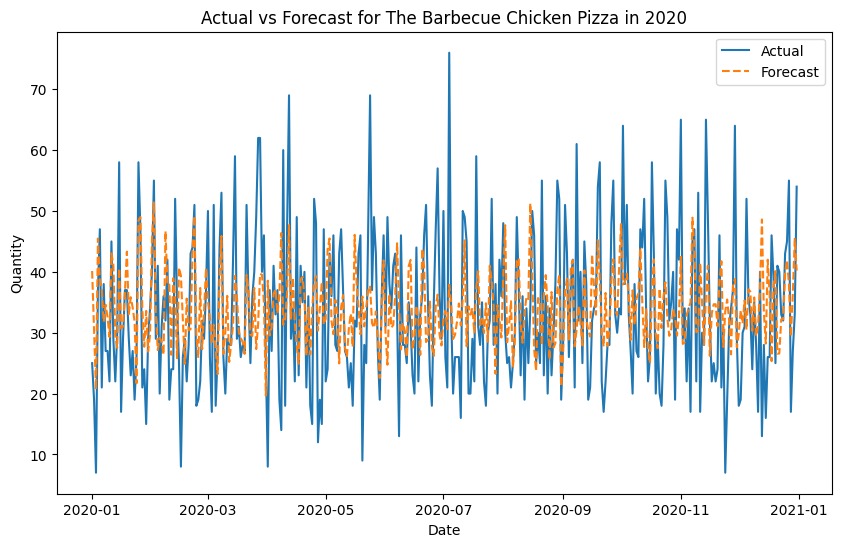

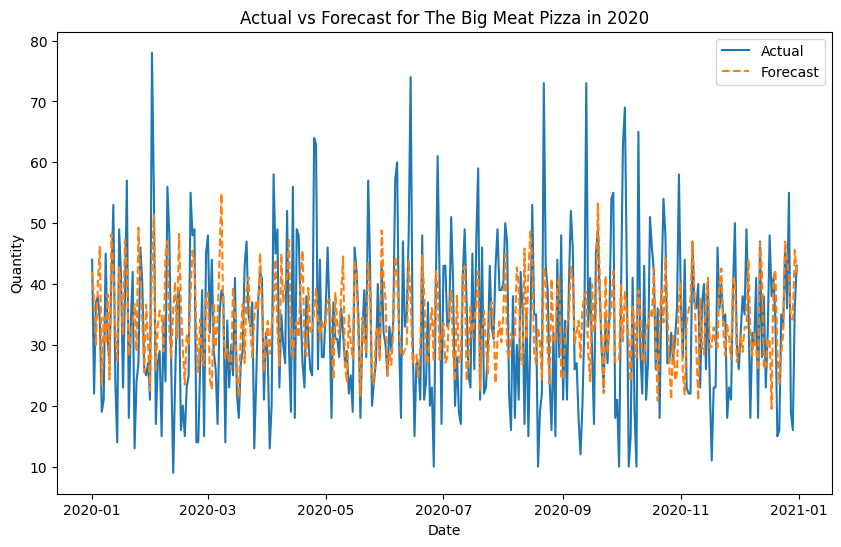

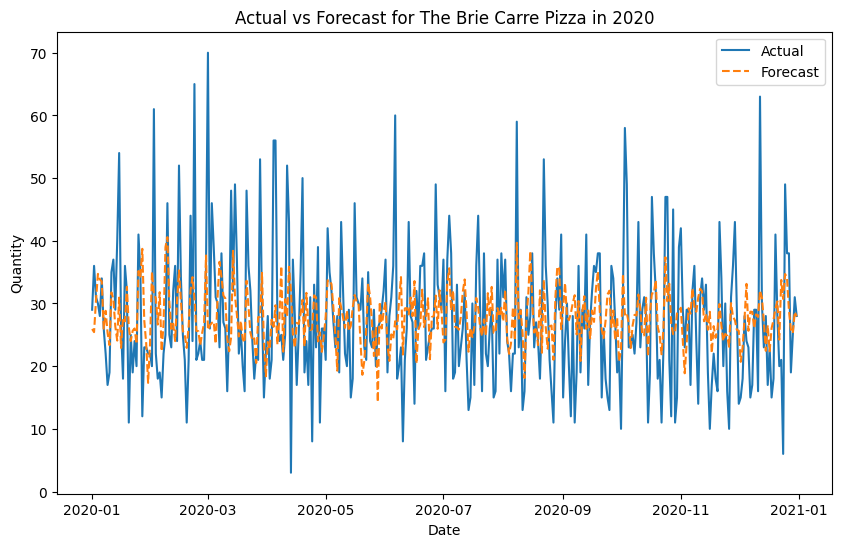

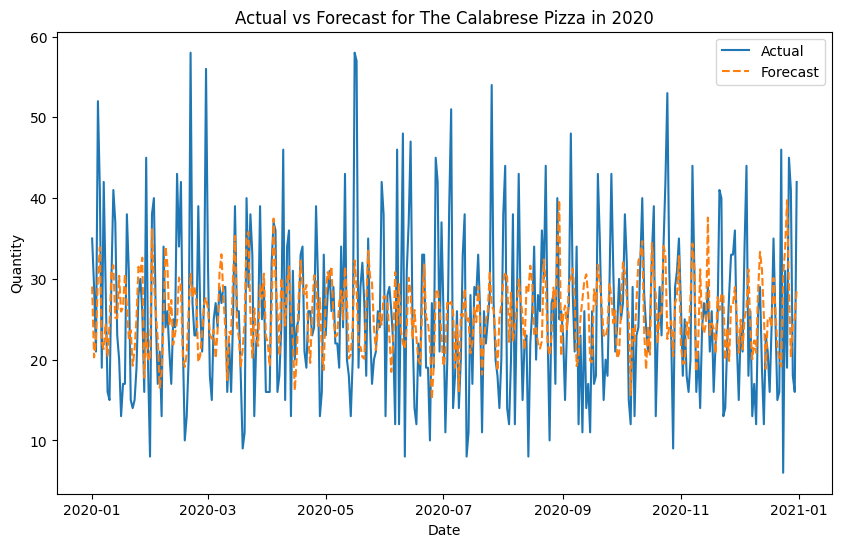

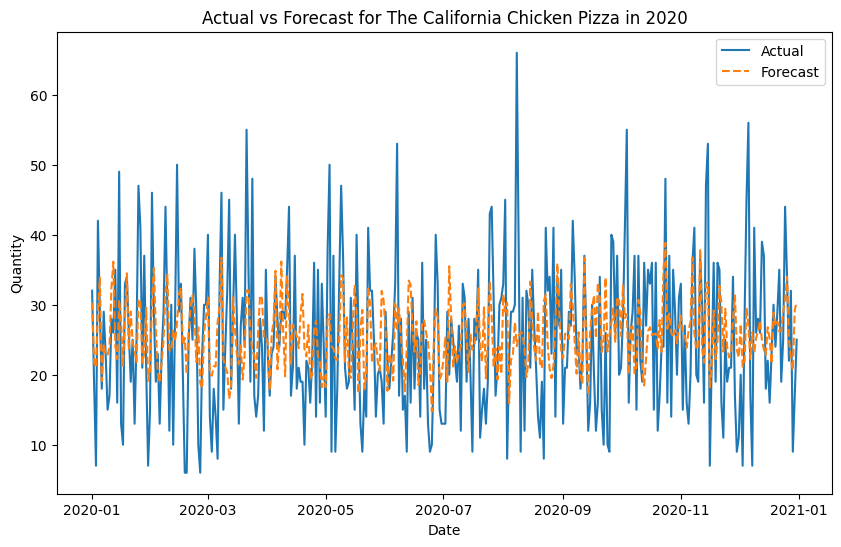

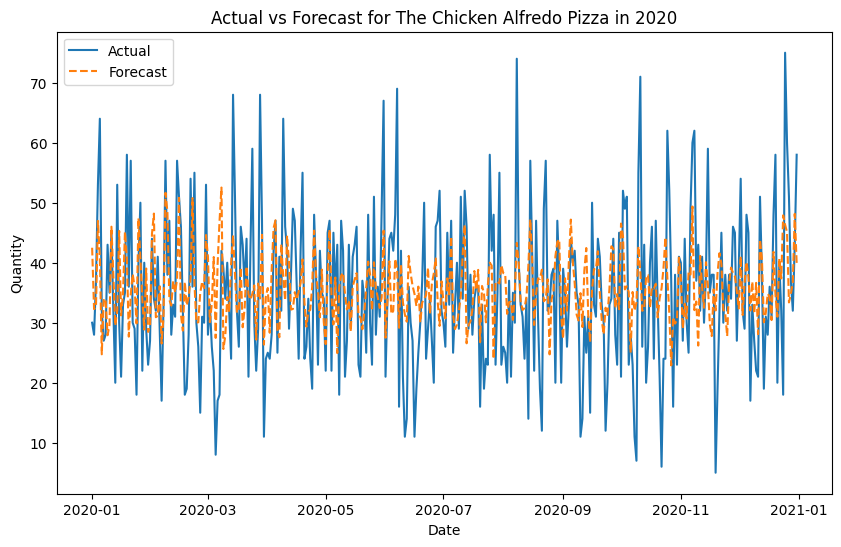

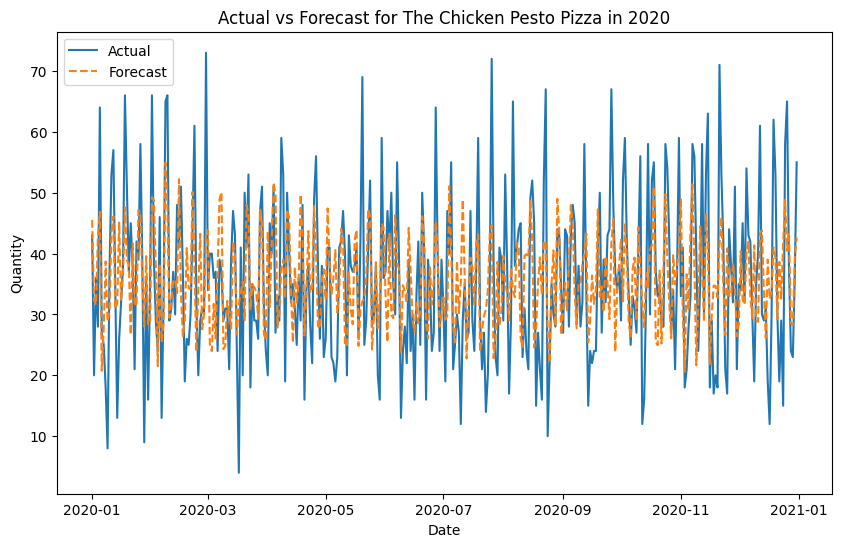

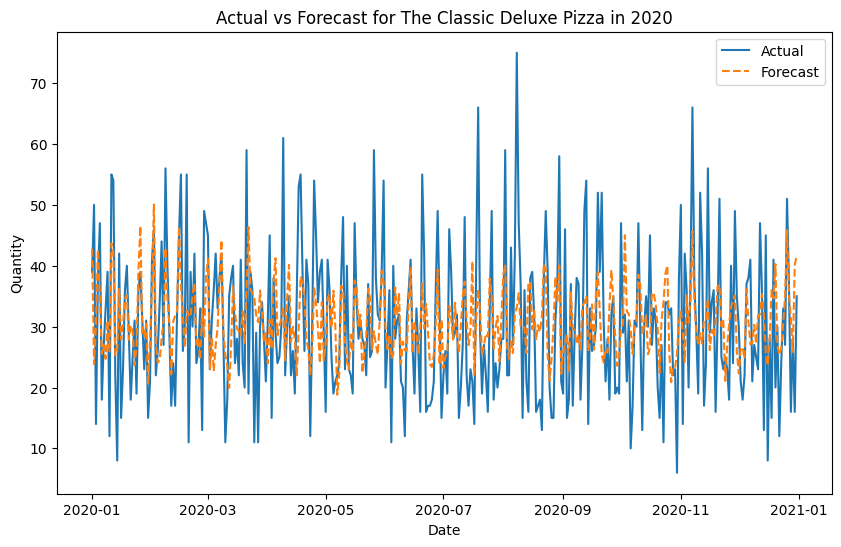

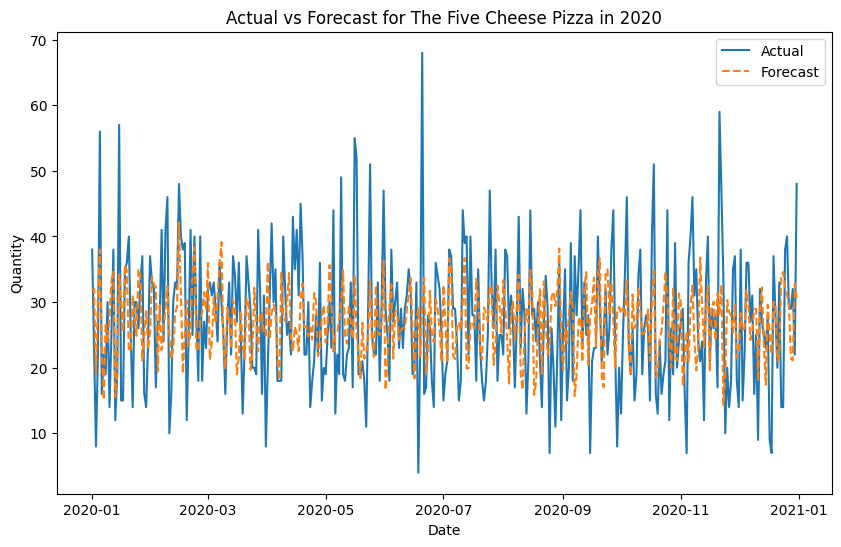

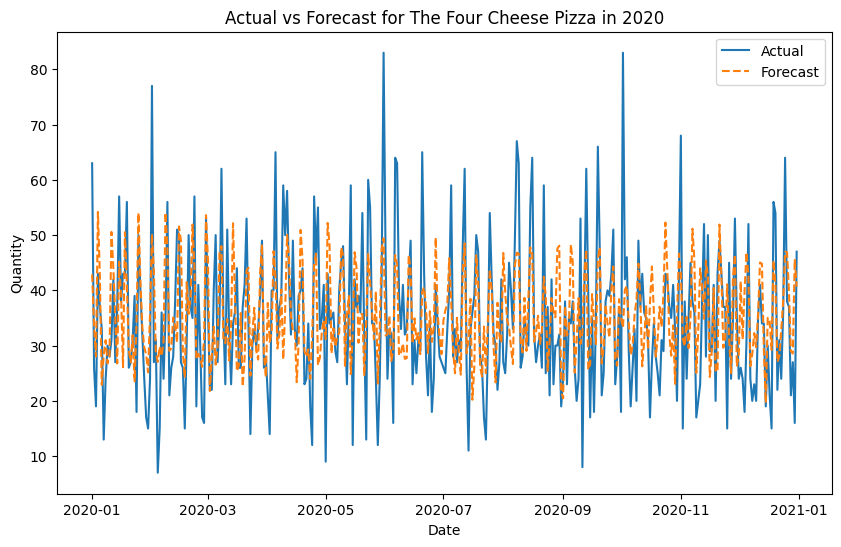

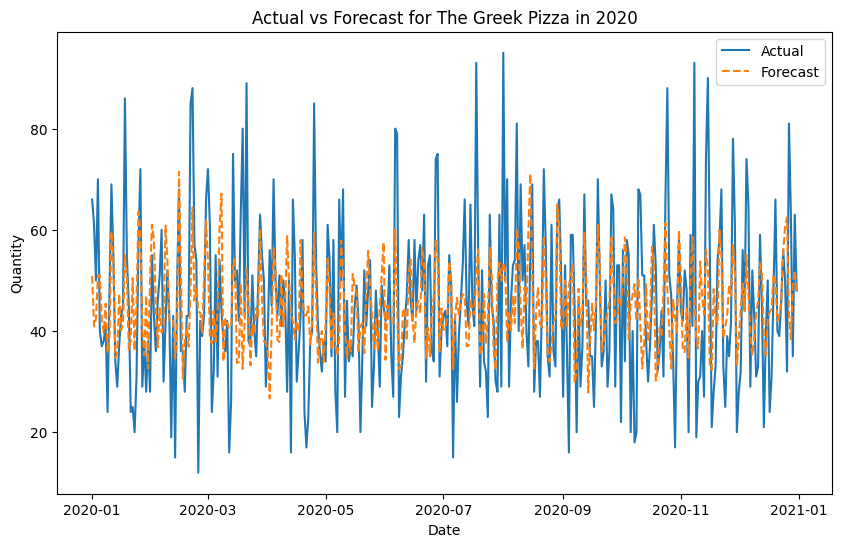

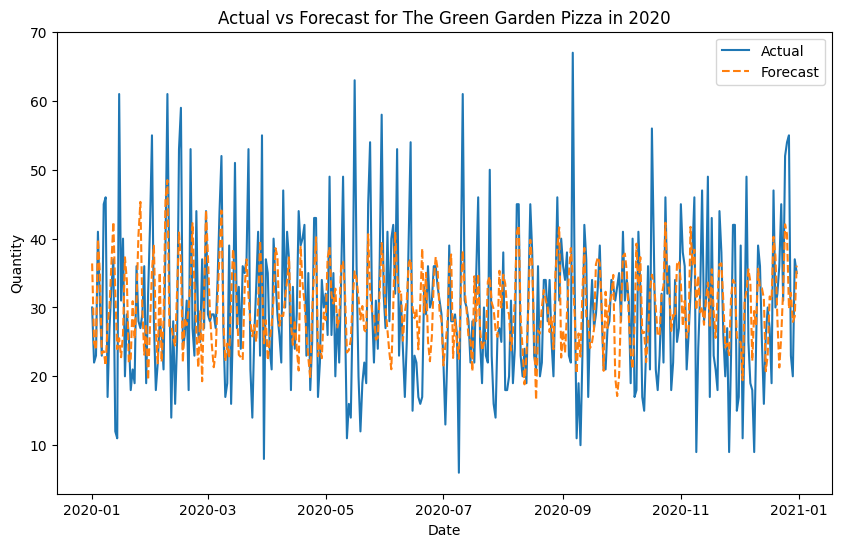

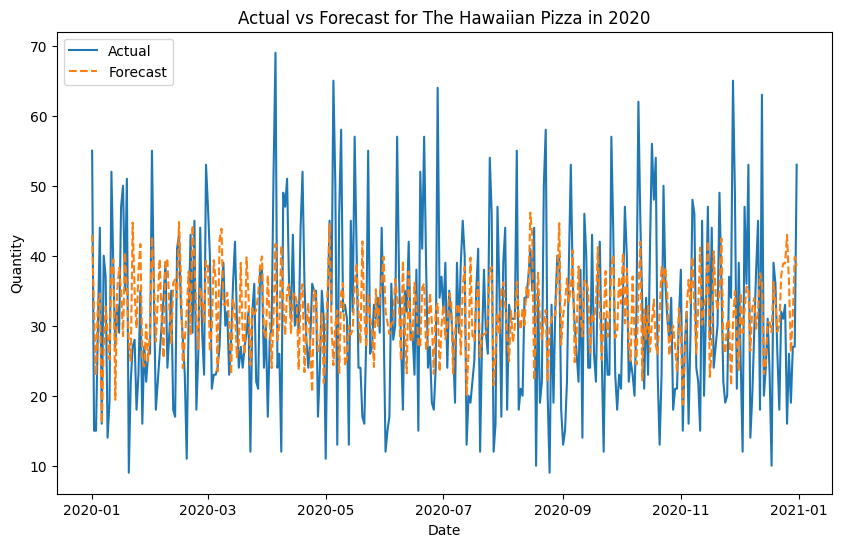

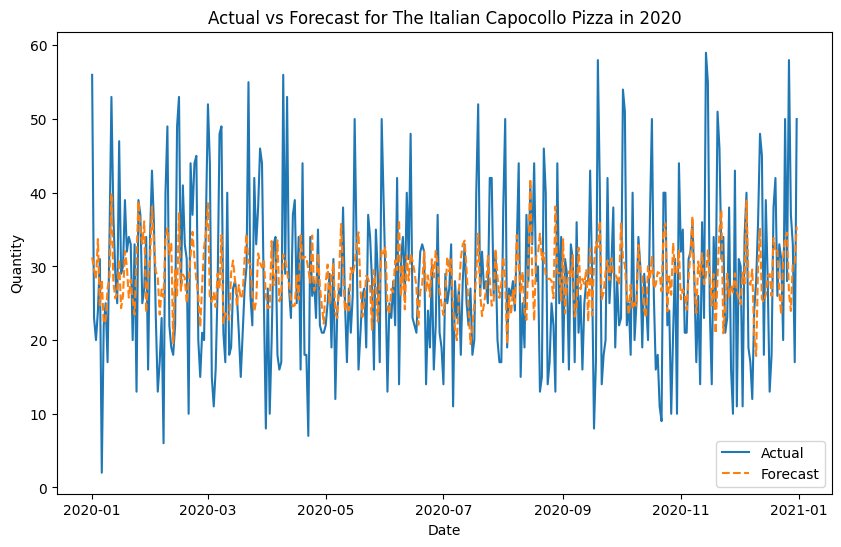

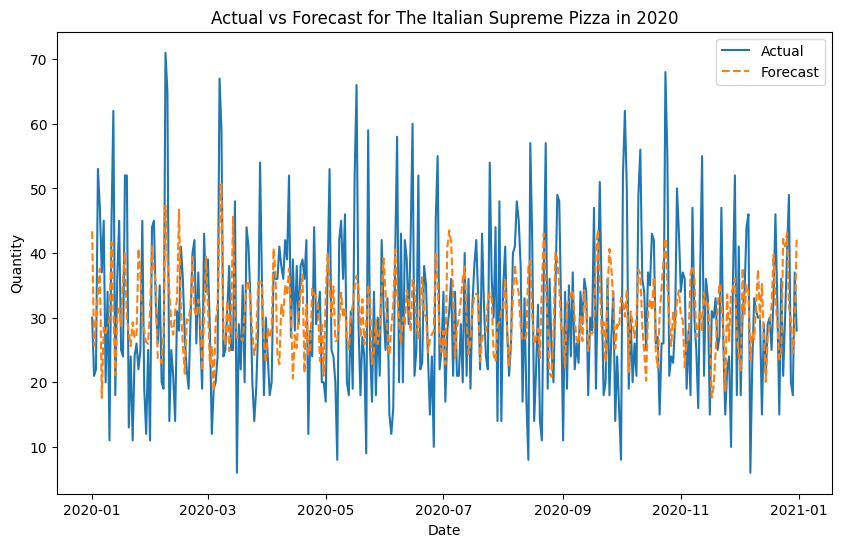

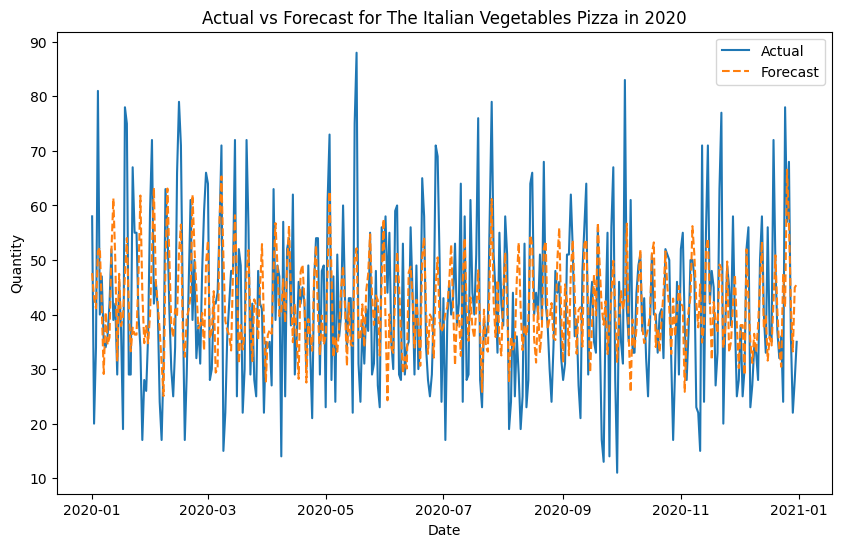

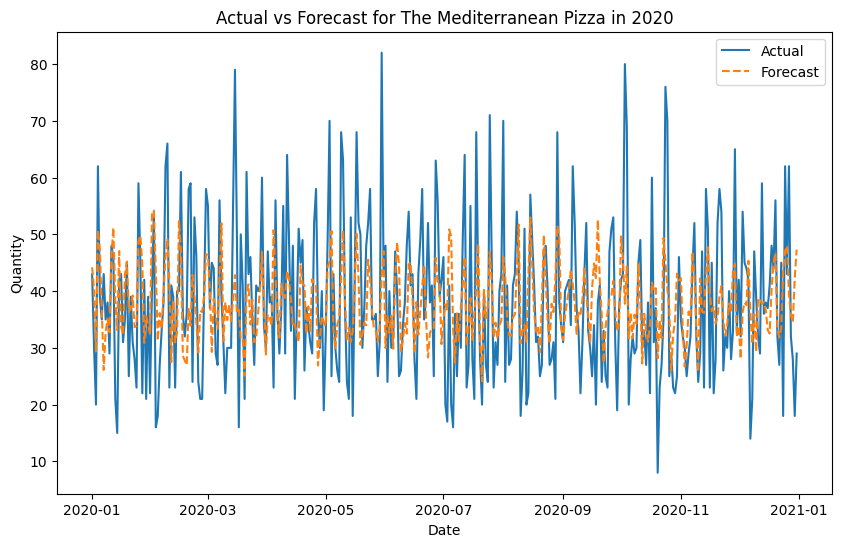

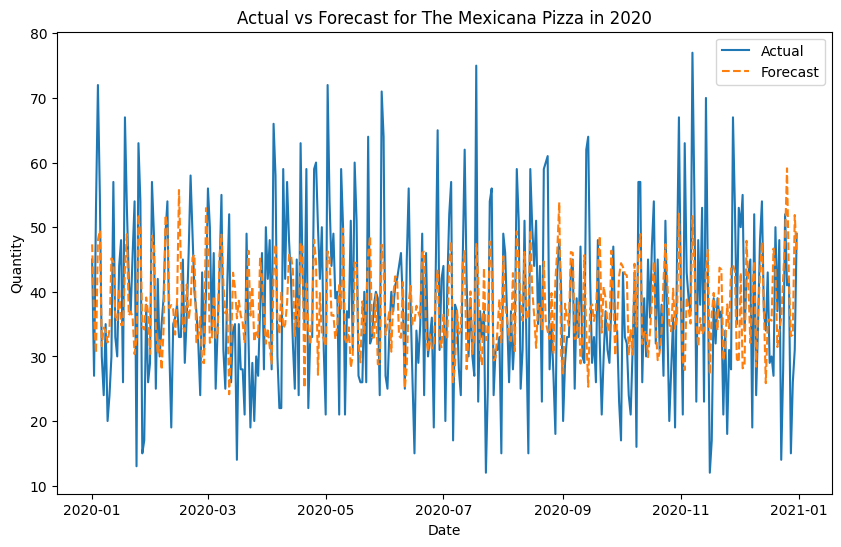

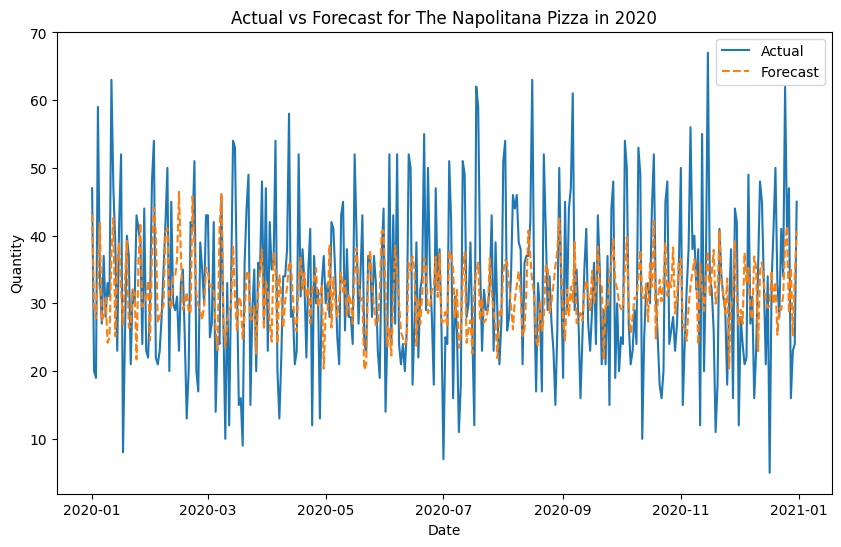

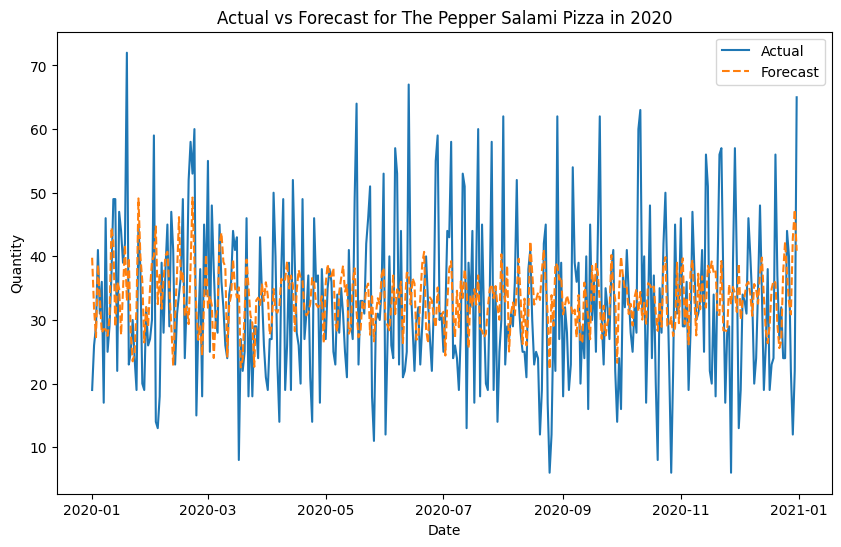

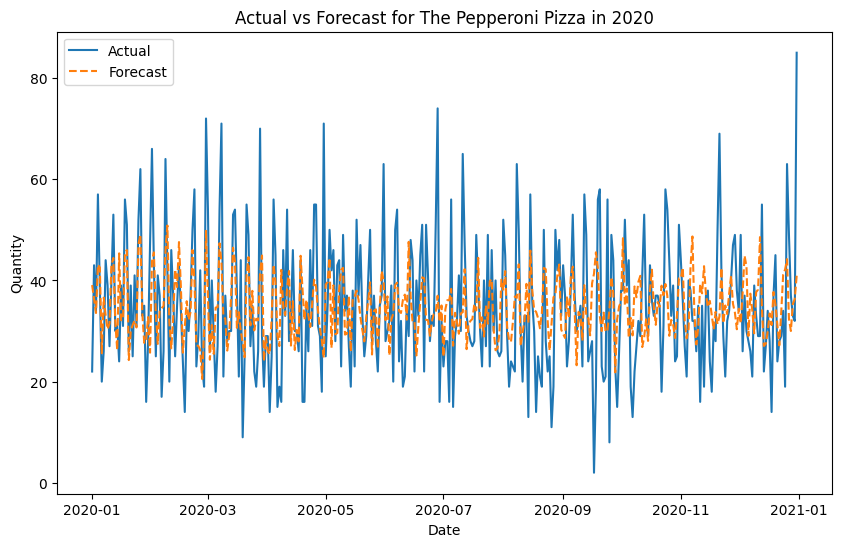

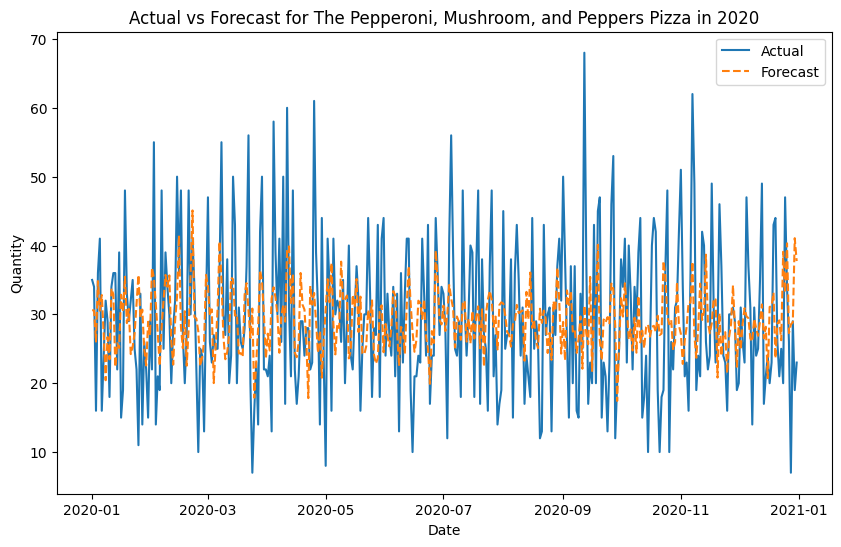

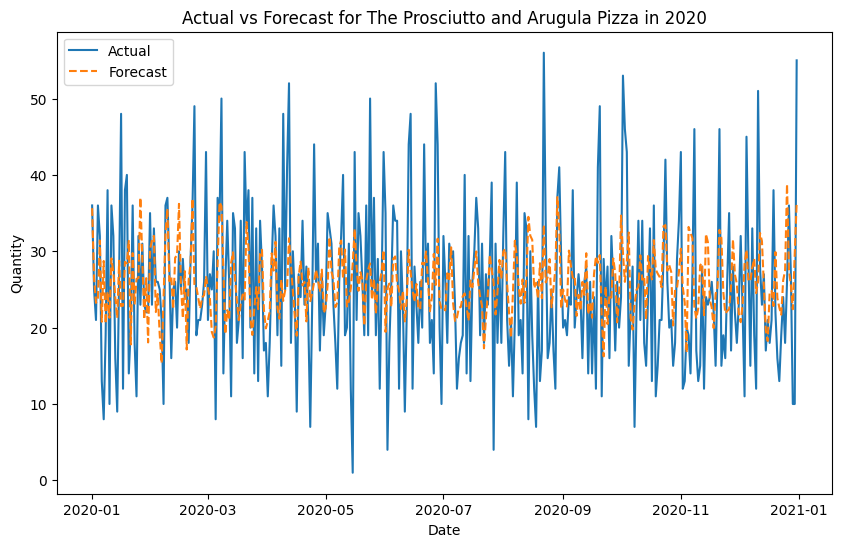

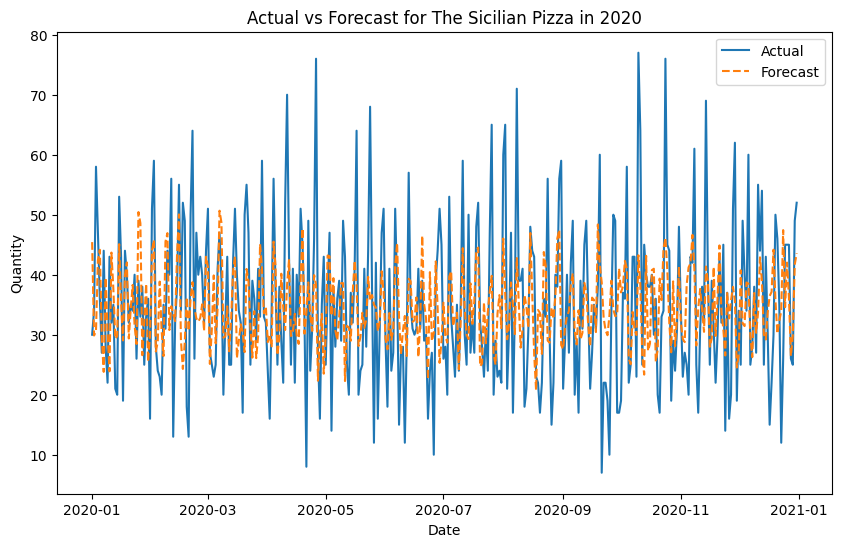

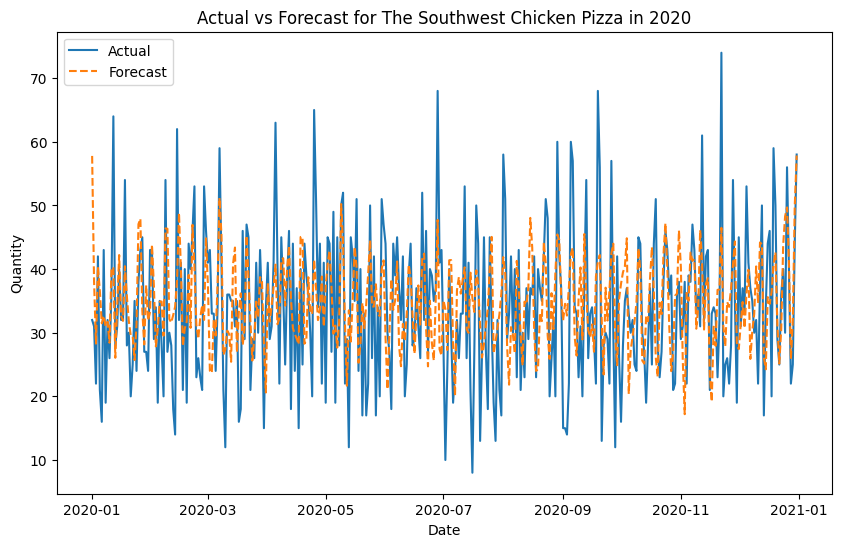

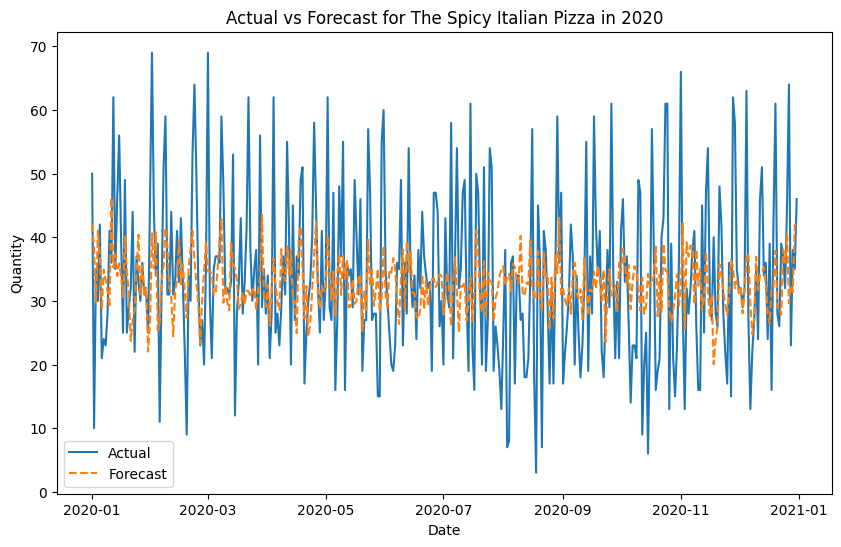

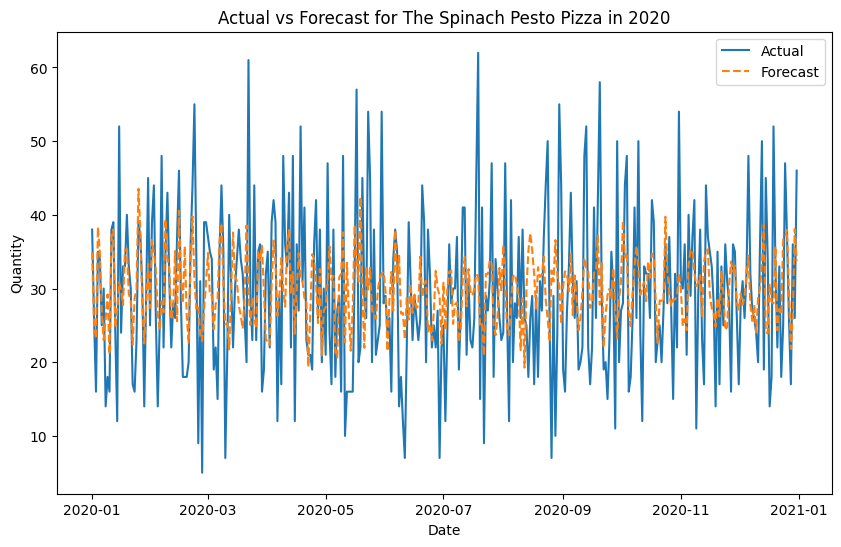

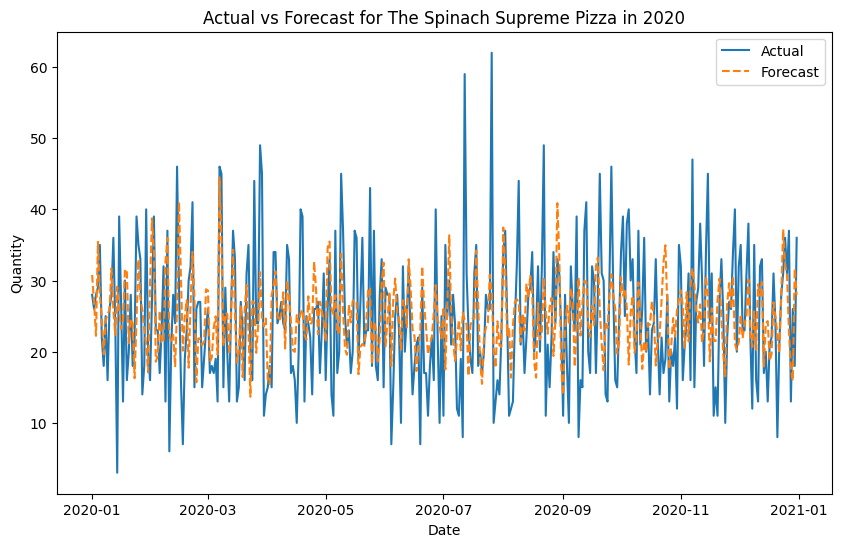

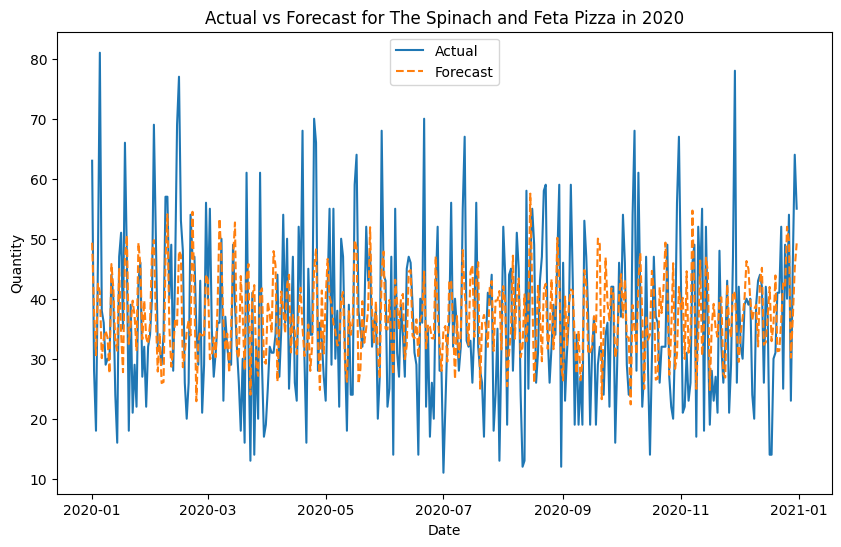

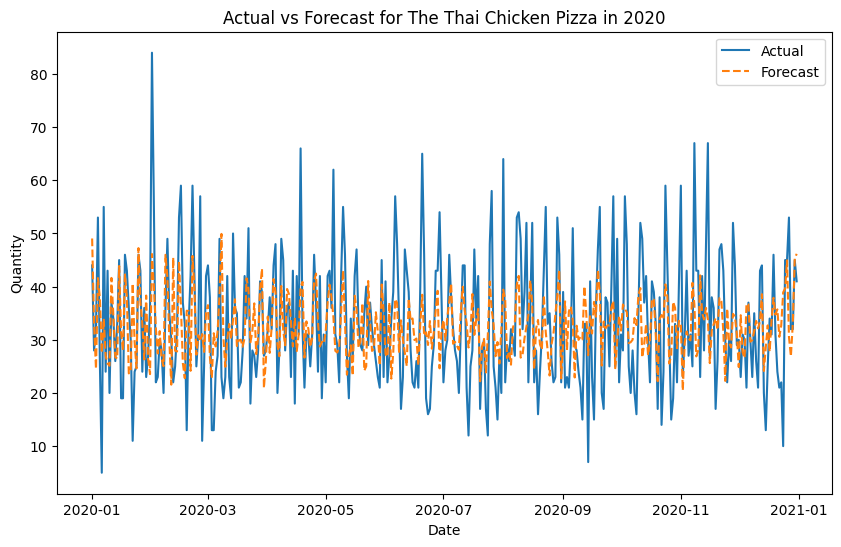

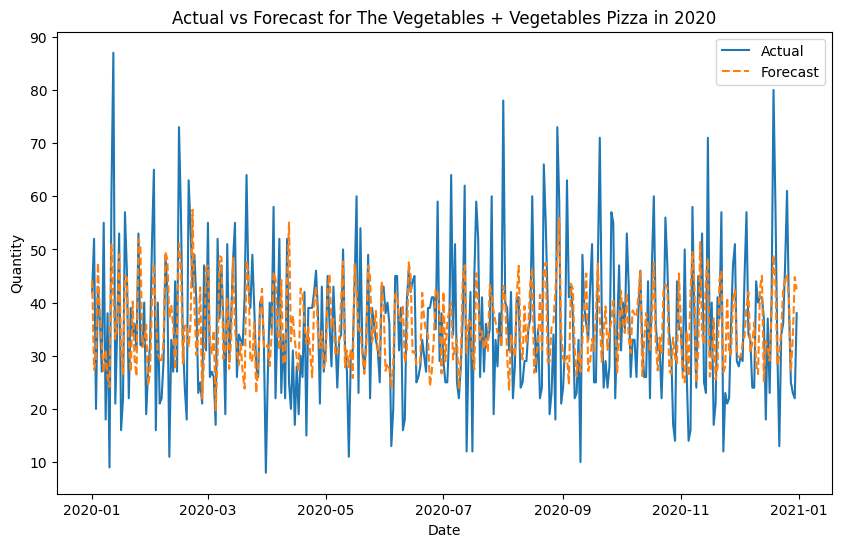


Metrics for The Barbecue Chicken Pizza:
Best Period: 90
RMSE: 11.206593077752645
MAE: 8.887481614989843
MAPE: 33.120461537975636
Accuracy: 66.87953846202436%

Metrics for The Big Meat Pizza:
Best Period: 30
RMSE: 11.099580095115217
MAE: 9.01606455458986
MAPE: 34.429304884963116
Accuracy: 65.57069511503688%

Metrics for The Brie Carre Pizza:
Best Period: 90
RMSE: 9.626503551177537
MAE: 7.431339312635306
MAPE: 34.40714762701572
Accuracy: 65.59285237298428%

Metrics for The Calabrese Pizza:
Best Period: 30
RMSE: 8.777904985224106
MAE: 6.868601592333823
MAPE: 32.720495260696765
Accuracy: 67.27950473930323%

Metrics for The California Chicken Pizza:
Best Period: 90
RMSE: 9.620038687600074
MAE: 7.773827252665414
MAPE: 42.6859649676857
Accuracy: 57.3140350323143%

Metrics for The Chicken Alfredo Pizza:
Best Period: 30
RMSE: 11.782197422451071
MAE: 9.344560343650624
MAPE: 36.31230351995761
Accuracy: 63.68769648004239%

Metrics for The Chicken Pesto Pizza:
Best Period: 30
RMSE: 11.535549865982

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Load the dataset from both sheets
data_dict = pd.read_excel('C:/Users/Abhishek Bhat/sam9.xlsx', sheet_name=None)

# Concatenate DataFrames from all sheets into a single DataFrame
data = pd.concat(data_dict.values(), ignore_index=True)

# Extract pizza ingredients information
pizza_ingredients = data[['pizza_name', 'pizza_ingredients']].drop_duplicates()

# Now you can work with the combined data DataFrame
# Convert 'order_date' column to datetime
data['order_date'] = pd.to_datetime(data['order_date'])

# Filter data for training (2010-01-01 to 2019-12-31)
train_data = data[(data['order_date'] >= '2010-01-01') & (data['order_date'] <= '2019-12-31')]

# Aggregating sales data on a daily basis for each pizza name
daily_sales = train_data.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack(fill_value=0)

# Handle missing values
daily_sales = daily_sales.asfreq('D').fillna(0)

# Prepare empty DataFrame for forecasted values
forecast_2020 = pd.DataFrame(index=pd.date_range(start='2020-01-01', end='2020-12-31'))

# Prepare dictionary to store metrics
errors = {}

# Prepare actual sales data for 2020
actual_data_2020 = data[(data['order_date'] >= '2020-01-01') & (data['order_date'] <= '2020-12-31')]
actual_daily_sales_2020 = actual_data_2020.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack(fill_value=0)

# Iterate over each pizza name
for pizza_name in daily_sales.columns:
    best_rmse = float('inf')
    best_period = None
    best_forecast = None

    for period in [7, 30, 90, 365]:
        # Seasonal decomposition
        decomposition = seasonal_decompose(daily_sales[pizza_name], model='additive', period=period)
        seasonal = decomposition.seasonal

        # Remove seasonality
        daily_sales[f'{pizza_name}_deseasonalized'] = daily_sales[pizza_name] - seasonal

        # Check Stationarity
        result = adfuller(daily_sales[f'{pizza_name}_deseasonalized'].dropna())

        # Apply differencing if necessary
        if result[1] > 0.05:
            daily_sales[f'{pizza_name}_deseasonalized'] = daily_sales[f'{pizza_name}_deseasonalized'].diff().dropna()

        # Set ARIMA parameters
        p, d, q = 7, 1, 7

        # Fit ARIMA model with specified parameters
        print(f'Fitting ARIMA({p},{d},{q}) model for {pizza_name} with period {period}')
        model = ARIMA(daily_sales[f'{pizza_name}_deseasonalized'].dropna(), order=(p, d, q))
        model_fit = model.fit()

        # Restore seasonality and forecast for 2020
        forecast_deseasonalized = model_fit.forecast(steps=366)
        forecast_2020[pizza_name] = forecast_deseasonalized + seasonal[-366:].values

        # Calculate RMSE for the current period
        rmse = np.sqrt(mean_squared_error(actual_daily_sales_2020[pizza_name], forecast_2020[pizza_name]))

        # Update best RMSE and period
        if rmse < best_rmse:
            best_rmse = rmse
            best_period = period
            best_forecast = forecast_2020[pizza_name]

    # Print the best period after iteration for each pizza
    print(f'Best period for {pizza_name}: {best_period}')

    # Store best period in dictionary
    errors[pizza_name] = {'Best Period': best_period}

    # Calculate and store additional metrics for the best forecast
    mae = mean_absolute_error(actual_daily_sales_2020[pizza_name], best_forecast)
    mape = np.mean(np.abs((actual_daily_sales_2020[pizza_name] - best_forecast) / actual_daily_sales_2020[pizza_name])) * 100
    accuracy = 100 - mape
    errors[pizza_name].update({'RMSE': best_rmse, 'MAE': mae, 'MAPE': mape, 'Accuracy': accuracy})

# Create a DataFrame to store metrics and ingredients
metrics_df = pd.DataFrame(errors).T
metrics_df = metrics_df.reset_index().rename(columns={'index': 'pizza_name'})
metrics_df = metrics_df.merge(pizza_ingredients, on='pizza_name', how='left')

# Save the metrics and ingredients to the first sheet of an Excel file
with pd.ExcelWriter('forecast_metrics.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

    # Save actual and predicted values for each pizza to separate sheets
    for pizza_name in forecast_2020.columns:
        # Limit sheet name to 31 characters
        sheet_name = pizza_name[:31]
        comparison_df = pd.DataFrame({
            'Actual': actual_daily_sales_2020[pizza_name],
            'Predicted': forecast_2020[pizza_name]
        })
        comparison_df.to_excel(writer, sheet_name=sheet_name, index=True)

# Plotting the actual and forecast data for each pizza name
for pizza_name in forecast_2020.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(actual_daily_sales_2020.index, actual_daily_sales_2020[pizza_name], label='Actual')
    plt.plot(forecast_2020.index, forecast_2020[pizza_name], linestyle='--', label='Forecast')
    plt.title(f'Actual vs Forecast for {pizza_name} in 2020')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

# Print metrics for each pizza name
for pizza_name, error_metrics in errors.items():
    print(f'\nMetrics for {pizza_name}:')
    print(f"Best Period: {error_metrics['Best Period']}")
    print(f"RMSE: {error_metrics['RMSE']}")
    print(f"MAE: {error_metrics['MAE']}")
    print(f"MAPE: {error_metrics['MAPE']}")
    print(f"Accuracy: {error_metrics['Accuracy']}%")

# Calculate and print the overall accuracy
average_accuracy = np.mean([error_metrics['Accuracy'] for error_metrics in errors.values()])
print(f'\nOverall Accuracy of all pizzas: {average_accuracy:.2f}%')

print("\nActual Quantity for 2020:")
print(actual_daily_sales_2020)

print("\nPredicted Quantity for 2020:")
print(forecast_2020)
